In [2]:
import matplotlib
import sys
import os
current_dir = os.path.dirname(os.path.abspath('./'))
if not current_dir in sys.path:
    sys.path.append(current_dir)
    
from utils.structures import Pipeline, Deploy
from utils.data_management import dict2str
from utils.machine_learning import one_hot_encoder, one_hot_decoder
from typing import *
import tensorflow as tf
from sklearn.datasets import make_classification
import mne
from combiners import EpochsCombiner
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from utils.machine_learning.designer import ModelDesign, ParallelDesign, LayerDesign
from utils.machine_learning.analyzer import ModelAnalyzer, LFCNNAnalyzer
from mne.datasets import multimodal
import sklearn
import mneflow as mf
import tensorflow as tf
from mneflow.layers import DeMixing, LFTConv, TempPooling, Dense

# %matplotlib qt

2022-03-07 10:58:09.328946: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-07 10:58:09.328975: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
mne.set_log_level(verbose='CRITICAL')
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)
cond = raw.acqparser.get_condition(raw, None)
condition_names = [k for c in cond for k,v in c['event_id'].items()]
epochs_list = [mne.Epochs(raw, **c) for c in cond]
epochs = mne.concatenate_epochs(epochs_list)
epochs = epochs.pick_types(meg='grad')
X = np.array([])
Y = list()
for i, epochs in enumerate(epochs_list):
    data = epochs.get_data()
    if i == 0:
        X = data.copy()
    else:
        X = np.append(X, data, axis=0)
    Y += [i for _ in range(data.shape[0])]

Y = np.array(Y)
X = np.array([X[i, epochs._channel_type_idx['grad'], :] for i, _ in enumerate(X)])
original_X = X.copy()
original_Y = Y.copy()

In [4]:
Y = original_Y.copy()
Y = one_hot_encoder(Y)

In [5]:
X = original_X.copy()
X = np.transpose(np.expand_dims(X, axis = 1), (0, 1, 3, 2))
print(X.shape)

(940, 1, 361, 204)


In [6]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y)

In [8]:


specs = dict()
specs.setdefault('filter_length', 7)
specs.setdefault('n_latent', 32)
specs.setdefault('pooling', 2)
specs.setdefault('stride', 2)
specs.setdefault('padding', 'SAME')
specs.setdefault('pool_type', 'max')
specs.setdefault('nonlin', tf.nn.relu)
specs.setdefault('l1', 3e-4)
specs.setdefault('l2', 0)
# specs.setdefault('l1_scope', ['fc', 'demix', 'lf_conv'])
specs.setdefault('l1_scope', ['fc', 'dmx', 'tconv', 'fc'])
specs.setdefault('l2_scope', [])
specs.setdefault('maxnorm_scope', [])
specs.setdefault('dropout', .5)

# n_latent=32,
# filter_length=17,
# nonlin = tf.nn.relu,
# padding = 'SAME',
# pooling = 5,
# stride = 5,
# pool_type='max',
# dropout = .5,
# l1_scope = ["weights"],
# l1=3e-3

specs['filter_length'] = 17
specs['pooling'] = 5
specs['stride'] = 5
specs['l1'] = 3e-3


out_dim = len(np.unique(original_Y))

n_samples, _, n_times, n_channels = X.shape

inputs = tf.keras.Input(shape=(1, n_times, n_channels))
print('input shape: ', inputs.shape)

dmx = DeMixing(size=specs['n_latent'], nonlin=tf.identity,
                            axis=3, specs=specs)
dmx_out = dmx(inputs)

tconv = LFTConv(size=specs['n_latent'],
                        nonlin=specs['nonlin'],
                        filter_length=specs['filter_length'],
                        padding=specs['padding'],
                        specs=specs
                        )
tconv_out = tconv(dmx_out)

pool = TempPooling(pooling=specs['pooling'],
                            pool_type=specs['pool_type'],
                            stride=specs['stride'],
                            padding=specs['padding'],
                            )
pooled = pool(tconv_out)

dropout = tf.keras.layers.Dropout(specs['dropout'],
                    noise_shape=None)(pooled)

fin_fc = Dense(size=out_dim, nonlin=tf.identity,
                    specs=specs)

y_pred = fin_fc(dropout)

print('output shape: ', y_pred.shape)

km = tf.keras.Model(inputs=inputs, outputs=y_pred)

optimizer="adam"
learn_rate=3e-4
params = {"optimizer": tf.optimizers.get(optimizer).from_config({"learning_rate":learn_rate})}
params.setdefault("loss", tf.nn.softmax_cross_entropy_with_logits)
params.setdefault("metrics", tf.keras.metrics.CategoricalAccuracy(name="cat_ACC"))

km.compile(optimizer=params["optimizer"],
                loss=params["loss"],
                metrics=params["metrics"])


# Setting reg for dmx, to l1
# Built: dmx input: (None, 1, 361, 204)
# Setting reg for tconv, to l1
# Built: tconv input: (None, 1, 361, 32)
# Setting reg for fc, to l1
# Built: fc input: (None, 1, 37, 32)
# Input shape: (1, 361, 204)
# y_pred: (None, 8)
# Initialization complete!

input shape:  (None, 1, 361, 204)
Setting reg for dmx, to l1
Built: dmx input: (None, 1, 361, 204)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 361, 32)
Setting reg for fc, to l1
Built: fc input: (None, 1, 37, 32)
output shape:  (None, 8)


In [64]:


specs = dict()
specs.setdefault('filter_length', 7)
specs.setdefault('n_latent', 32)
specs.setdefault('pooling', 2)
specs.setdefault('stride', 2)
specs.setdefault('padding', 'SAME')
specs.setdefault('pool_type', 'max')
specs.setdefault('nonlin', tf.nn.relu)
specs.setdefault('l1', 3e-4)
specs.setdefault('l2', 0)
# specs.setdefault('l1_scope', ['fc', 'demix', 'lf_conv'])
specs.setdefault('l1_scope', ['fc', 'dmx', 'tconv', 'fc'])
specs.setdefault('l2_scope', [])
specs.setdefault('maxnorm_scope', [])
specs.setdefault('dropout', .5)

# n_latent=32,
# filter_length=17,
# nonlin = tf.nn.relu,
# padding = 'SAME',
# pooling = 5,
# stride = 5,
# pool_type='max',
# dropout = .5,
# l1_scope = ["weights"],
# l1=3e-3

specs['filter_length'] = 17
specs['pooling'] = 5
specs['stride'] = 5
specs['l1'] = 3e-3


out_dim = len(np.unique(original_Y))

n_samples, _, n_times, n_channels = X.shape

inputs = tf.keras.Input(shape=(1, n_times, n_channels))

kmd = ModelDesign(
    tf.keras.Input(shape=(1, n_times, n_channels)),
    DeMixing(size=specs['n_latent'], nonlin=tf.identity, axis=3, specs=specs),
    LFTConv(
        size=specs['n_latent'],
        nonlin=specs['nonlin'],
        filter_length=specs['filter_length'],
        padding=specs['padding'],
        specs=specs
    ),
    TempPooling(
        pooling=specs['pooling'],
        pool_type=specs['pool_type'],
        stride=specs['stride'],
        padding=specs['padding'],
    ),
    tf.keras.layers.Dropout(specs['dropout'], noise_shape=None),
    Dense(size=out_dim, nonlin=tf.identity, specs=specs)
)

# kmd = ModelDesign(
#     tf.keras.Input(shape=(1, n_times, n_channels)),
#     DeMixing(size=specs['n_latent'], nonlin=tf.identity, axis=3, specs=specs),
#     LFTConv(
#         size=specs['n_latent'],
#         nonlin=specs['nonlin'],
#         filter_length=specs['filter_length'],
#         padding=specs['padding'],
#         specs=specs
#     ),
#     TempPooling(
#         pooling=specs['pooling'],
#         pool_type=specs['pool_type'],
#         stride=specs['stride'],
#         padding=specs['padding'],
#     ),
#     tf.keras.layers.DepthwiseConv2D((1, 37), padding='valid', activation='relu', kernel_regularizer='l1'),
#     # tf.keras.layers.Dropout(specs['dropout'], noise_shape=None),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(out_dim),
#     Dense(size=out_dim, nonlin=tf.identity, specs=specs)
# )
print(kmd().shape)


Setting reg for fc, to l1
Setting reg for dmx, to l1
Built: dmx input: (None, 1, 361, 204)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 361, 32)
Built: fc input: (None, 1, 37, 32)
(None, 8)


In [65]:
km = kmd.build()

optimizer="adam"
learn_rate=3e-4
params = {"optimizer": tf.optimizers.get(optimizer).from_config({"learning_rate":learn_rate})}
params.setdefault("loss", tf.nn.softmax_cross_entropy_with_logits)
params.setdefault("metrics", tf.keras.metrics.CategoricalAccuracy(name="cat_ACC"))

km.compile(optimizer=params["optimizer"],
                loss=params["loss"],
                metrics=params["metrics"])

importing from tuple
input shapes: X- (940, 204, 361) targets- (940, 1)
Preprocessing:
Scaling to interval 0.0 - 60.0
Splitting sets
Preprocessed: (940, 1, 361, 204) (940, 8) folds: 5 x 188
Prepocessed sample shape: (1, 361, 204)
Target shape actual/metadata:  (8,) (8,)
Saving TFRecord# 0
Epoch 1/300
10/10 - 1s - loss: 5.6542 - cat_ACC: 0.0977 - val_loss: 5.0360 - val_cat_ACC: 0.1223 - 1s/epoch - 100ms/step
Epoch 2/300
10/10 - 0s - loss: 5.3585 - cat_ACC: 0.1208 - val_loss: 4.8994 - val_cat_ACC: 0.1436 - 420ms/epoch - 42ms/step
Epoch 3/300
10/10 - 0s - loss: 5.2284 - cat_ACC: 0.1450 - val_loss: 4.8438 - val_cat_ACC: 0.1649 - 401ms/epoch - 40ms/step
Epoch 4/300
10/10 - 0s - loss: 5.0390 - cat_ACC: 0.1792 - val_loss: 4.8080 - val_cat_ACC: 0.1489 - 417ms/epoch - 42ms/step
Epoch 5/300
10/10 - 0s - loss: 5.0654 - cat_ACC: 0.1397 - val_loss: 4.7701 - val_cat_ACC: 0.1596 - 414ms/epoch - 41ms/step
Epoch 6/300
10/10 - 0s - loss: 4.9719 - cat_ACC: 0.1555 - val_loss: 4.7261 - val_cat_ACC: 0.1649 

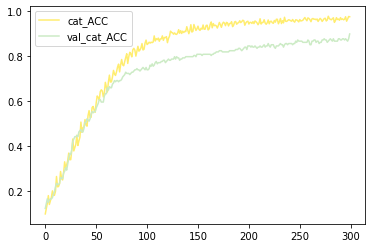

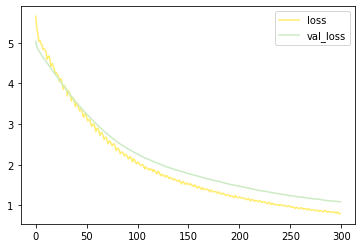

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [66]:
import mneflow
import_opt = dict(savepath='../tfr/',
                  out_name='mne_sample_epochs',
                  fs=600,
                  input_type='trials',
                  target_type='int',
                  picks={'meg':'grad'},
                  scale=True,  # apply baseline_scaling
                  crop_baseline=True,  # remove baseline interval after scaling
                  decimate=None,
                  scale_interval=(0, 60),  # indices in time axis corresponding to baseline interval
                #   n_folds=5,  # validation set size set to 20% of all data
                  n_folds=5,
                  overwrite=True,
                  segment=False,
                #   test_set='holdout'
)


#write TFRecord files and metadata file to disk
meta = mneflow.produce_tfrecords((original_X, original_Y), **import_opt)  
dataset = mneflow.Dataset(meta, train_batch=100)

train_size = dataset.h_params['train_size']
eval_step = train_size // dataset.h_params['train_batch'] + 1
min_delta=1e-6
early_stopping=3
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      min_delta=min_delta,
                                                      patience=early_stopping,
                                                      restore_best_weights=True)

km.fit(dataset.train,
      validation_data=dataset.val,
      epochs=300, steps_per_epoch=eval_step,
      shuffle=True, 
      validation_steps=dataset.validation_steps,
      callbacks=[stop_early], verbose=2)

ma = ModelAnalyzer(km)
ma.plot_metrics(['cat_ACC', 'val_cat_ACC'])
ma.plot_metrics(['loss', 'val_loss'])

In [18]:
import sklearn.metrics as sm
from utils.machine_learning import one_hot_decoder
from utils.machine_learning.confusion import ConfusionEstimator

y_p_val = km(X).numpy()

print(
    'val acc',
    sm.accuracy_score(
        one_hot_decoder(Y),
        one_hot_decoder(y_p_val),
    )
)

# tn, fp, fn, tp = sm.confusion_matrix(one_hot_decoder(y_t_val), one_hot_decoder(y_p_val)).ravel()
# ce = ConfusionEstimator(tp, tn, fp, fn)

# print(
#     f'\tT\tF\n'\
#     f'P\t{tp}\t{fp}\n'\
#     f'N\t{tn}\t{fn}\n'
#     f'Accuracy: {ce.acc}\n'\
#     f'Specificity: {ce.spec}\n'\
#     f'Sensitivity: {ce.sens}'
# )
# y_t_train, y_p_train = km.predict(dataset.train)

# print(
#     'train acc',
#     sm.accuracy_score(
#         one_hot_decoder(y_t_train),
#         one_hot_decoder(y_p_train),
#     )
# )

# tn, fp, fn, tp = sm.confusion_matrix(one_hot_decoder(y_t_train), one_hot_decoder(y_p_train)).ravel()
# ce = ConfusionEstimator(tp, tn, fp, fn)

# print(
#     f'\tT\tF\n'\
#     f'P\t{tp}\t{fp}\n'\
#     f'N\t{tn}\t{fn}\n'
#     f'Accuracy: {ce.acc}\n'\
#     f'Specificity: {ce.spec}\n'\
#     f'Sensitivity: {ce.sens}'
# )

# y_t = np.concatenate([y_t_val, y_t_train], axis=0)
# y_p = np.concatenate([y_p_val, y_p_train], axis=0)


# print(
#     'total acc',
#     sm.accuracy_score(
#         one_hot_decoder(y_t),
#         one_hot_decoder(y_p),
#     )
# )
# tn, fp, fn, tp = sm.confusion_matrix(one_hot_decoder(y_t), one_hot_decoder(y_p)).ravel()
# ce = ConfusionEstimator(tp, tn, fp, fn)

# print(
#     f'\tT\tF\n'\
#     f'P\t{tp}\t{fp}\n'\
#     f'N\t{tn}\t{fn}\n'
#     f'Accuracy: {ce.acc}\n'\
#     f'Specificity: {ce.spec}\n'\
#     f'Sensitivity: {ce.sens}'
# )


val acc 0.125531914893617


In [11]:
km.fit(
    X,
    Y,
    epochs=25,
    validation_split=0.4,
    shuffle=True,
    batch_size=100,
)

Epoch 1/25
6/6 [==============================] - 0s 52ms/step - loss: 2.8302 - cat_ACC: 0.2074 - val_loss: 2.9959 - val_cat_ACC: 0.0000e+00
Epoch 2/25
6/6 [==============================] - 0s 29ms/step - loss: 2.7189 - cat_ACC: 0.2181 - val_loss: 3.1969 - val_cat_ACC: 0.0000e+00
Epoch 3/25
6/6 [==============================] - 0s 29ms/step - loss: 2.6102 - cat_ACC: 0.2039 - val_loss: 3.4478 - val_cat_ACC: 0.0000e+00
Epoch 4/25
6/6 [==============================] - 0s 30ms/step - loss: 2.5197 - cat_ACC: 0.2447 - val_loss: 3.6942 - val_cat_ACC: 0.0000e+00
Epoch 5/25
6/6 [==============================] - 0s 28ms/step - loss: 2.4592 - cat_ACC: 0.2553 - val_loss: 3.9114 - val_cat_ACC: 0.0000e+00
Epoch 6/25
6/6 [==============================] - 0s 29ms/step - loss: 2.4171 - cat_ACC: 0.2163 - val_loss: 4.0860 - val_cat_ACC: 0.0000e+00
Epoch 7/25
6/6 [==============================] - 0s 29ms/step - loss: 2.3745 - cat_ACC: 0.2128 - val_loss: 4.2153 - val_cat_ACC: 0.0000e+00
Epoch 8/25
6/

In [8]:
dataset.train

<MapDataset element_spec=(TensorSpec(shape=(None, 1, 361, 204), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.int64, name=None))>

In [13]:
# list(dataset.train.as_numpy_iterator())
